In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from IPython.display import clear_output

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

algorithm_globals.random_seed = 42

In [10]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [11]:
#circuit 01
circuit = QuantumCircuit(3)

#Input layer
circuit.ry(Parameter('i_1'),0)
circuit.ry(Parameter('i_2'),1)
circuit.ry(Parameter('i_3'),2)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit.rx(Parameter('w_1'),0)
circuit.crz(Parameter('w_12'),0,1)
circuit.rx(Parameter('w_2'),1)
circuit.crz(Parameter('w_23'),1,2)
circuit.rx(Parameter('w_3'),2)
circuit.crz(Parameter('w_13'),2,0)

circuit.draw()

┌─────────┐┌─────────┐                                              »
q_0: ┤ Ry(i_1) ├┤ Rx(w_1) ├─────■────────────────────────────────────────»
     ├─────────┤└─────────┘┌────┴─────┐┌─────────┐                       »
q_1: ┤ Ry(i_2) ├───────────┤ Rz(w_12) ├┤ Rx(w_2) ├─────■─────────────────»
     ├─────────┤           └──────────┘└─────────┘┌────┴─────┐┌─────────┐»
q_2: ┤ Ry(i_3) ├──────────────────────────────────┤ Rz(w_23) ├┤ Rx(w_3) ├»
     └─────────┘                                  └──────────┘└─────────┘»
«     ┌──────────┐
«q_0: ┤ Rz(w_13) ├
«     └────┬─────┘
«q_1: ─────┼──────
«          │      
«q_2: ─────■──────
«

In [12]:
#circuit 02
circuit = QuantumCircuit(4)

#Input layer
circuit.ry(Parameter('i_1'),0)
circuit.ry(Parameter('i_2'),1)
circuit.ry(Parameter('i_3'),2)
circuit.ry(Parameter('i_4'),3)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit.rx(Parameter('w_1'),0)
circuit.rx(Parameter('w_2'),1)
circuit.rx(Parameter('w_3'),2)
circuit.rx(Parameter('w_4'),3)
circuit.crz(Parameter('w_12'),0,1)
circuit.crz(Parameter('w_23'),1,2)
circuit.crz(Parameter('w_34'),2,3)
circuit.crz(Parameter('w_13'),3,0)

circuit.draw()

┌─────────┐┌─────────┐                                    ┌──────────┐
q_0: ┤ Ry(i_1) ├┤ Rx(w_1) ├─────■──────────────────────────────┤ Rz(w_13) ├
     ├─────────┤├─────────┤┌────┴─────┐                        └────┬─────┘
q_1: ┤ Ry(i_2) ├┤ Rx(w_2) ├┤ Rz(w_12) ├─────■───────────────────────┼──────
     ├─────────┤├─────────┤└──────────┘┌────┴─────┐                 │      
q_2: ┤ Ry(i_3) ├┤ Rx(w_3) ├────────────┤ Rz(w_23) ├─────■───────────┼──────
     ├─────────┤├─────────┤            └──────────┘┌────┴─────┐     │      
q_3: ┤ Ry(i_4) ├┤ Rx(w_4) ├────────────────────────┤ Rz(w_34) ├─────■──────
     └─────────┘└─────────┘                        └──────────┘

In [13]:
#circuit 03
circuit = QuantumCircuit(4)

#Input layer
circuit.ry(Parameter('i_1'),0)
circuit.ry(Parameter('i_2'),1)
circuit.ry(Parameter('i_3'),2)
circuit.ry(Parameter('i_4'),3)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit.rx(Parameter('w_x1'),0)
circuit.rx(Parameter('w_x2'),1)
circuit.rx(Parameter('w_x3'),2)
circuit.rx(Parameter('w_x4'),3)

circuit.ry(Parameter('w_y1'),0)
circuit.ry(Parameter('w_y2'),1)
circuit.ry(Parameter('w_y3'),2)
circuit.ry(Parameter('w_y4'),3)

circuit.rz(Parameter('w_z1'),0)
circuit.rz(Parameter('w_z2'),1)
circuit.rz(Parameter('w_z3'),2)
circuit.rz(Parameter('w_z4'),3)

circuit.draw()

┌─────────┐┌──────────┐┌──────────┐┌──────────┐
q_0: ┤ Ry(i_1) ├┤ Rx(w_x1) ├┤ Ry(w_y1) ├┤ Rz(w_z1) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_1: ┤ Ry(i_2) ├┤ Rx(w_x2) ├┤ Ry(w_y2) ├┤ Rz(w_z2) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_2: ┤ Ry(i_3) ├┤ Rx(w_x3) ├┤ Ry(w_y3) ├┤ Rz(w_z3) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_3: ┤ Ry(i_4) ├┤ Rx(w_x4) ├┤ Ry(w_y4) ├┤ Rz(w_z4) ├
     └─────────┘└──────────┘└──────────┘└──────────┘

Loading the adhoc data with size 100

In [14]:
df = pd.read_csv('datasets/adhoc_1000.csv', index_col=[0])
df.head()

,feature_1,feature_2,label
0,1.256637,5.215044,0.0
1,2.136283,4.084070,0.0
2,4.272566,0.816814,0.0
3,1.759292,0.439823,0.0
4,1.570796,3.267256,0.0


In [15]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration,  adhoc with datasize = 100")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

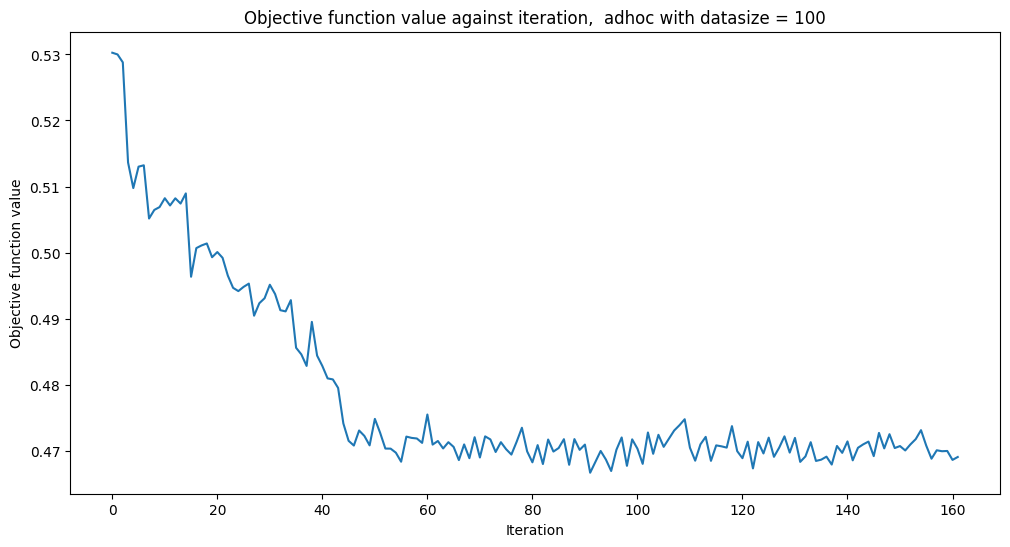

Score of circuit 1:  [0.46666667 0.57333333 0.57333333 0.61333333 0.61333333 0.53333333
 0.54666667 0.57333333 0.49333333 0.61333333]
Score of circuit 2:  [0.46666667 0.54666667 0.57333333 0.57333333 0.61333333 0.44
 0.50666667 0.57333333 0.54666667 0.56      ]
Score of circuit 3:  [0.49333333 0.6        0.57333333 0.57333333 0.61333333 0.58666667
 0.50666667 0.57333333 0.54666667 0.6       ]


In [16]:
datasize = 1000
output_shape = 2
cirtui1_score = []
cirtui2_score = []
cirtui3_score = []


for x in range(10):     
    print('iteration: ', x)
  
    # ======== setup data ========
    start = x * (datasize // 10)
    end = x * (datasize // 10) + 75

    if end < datasize-1:
        features = df.iloc[start:end, 0:2].values
        labels = df.iloc[start:end, 2:3].values.flatten()
    else:
        end = end - datasize
        features = df.iloc[start:datasize-1, 0:2].values
        labels = df.iloc[start:datasize-1, 2:3].values.flatten()
        for j in range(end+1):
            features = np.append(features, df.iloc[j:j+1, 0:2].values, axis=0)
        labels = np.append(labels, df.iloc[0:end+1, 2:3].values.flatten())

    def parity(x):
        return x%2
    
    # ======== circuit 1 ========

    circuit1_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:2],
                         weight_params=circuit.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit1_classifier= NeuralNetworkClassifier(neural_network=circuit1_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit1_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui1_score = np.append(cirtui1_score, circuit1_classifier.score(features, labels))
    
    # ======== circuit 2 ========

    circuit2_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:2],
                         weight_params=circuit.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit2_classifier= NeuralNetworkClassifier(neural_network=circuit2_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit2_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui2_score = np.append(cirtui2_score, circuit2_classifier.score(features, labels))
    
    # ======== circuit 3 ========

    circuit3_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:2],
                         weight_params=circuit.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit3_classifier= NeuralNetworkClassifier(neural_network=circuit3_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit3_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui3_score = np.append(cirtui3_score, circuit3_classifier.score(features, labels))
print('Score of circuit 1: ',cirtui1_score)
print('Score of circuit 2: ',cirtui2_score)
print('Score of circuit 3: ',cirtui3_score)

In [17]:
"""
Score of circuit 1:  [0.46666667 0.57333333 0.57333333 0.61333333 0.61333333 0.53333333
 0.54666667 0.57333333 0.49333333 0.61333333]
Score of circuit 2:  [0.46666667 0.54666667 0.57333333 0.57333333 0.61333333 0.44
 0.50666667 0.57333333 0.54666667 0.56      ]
Score of circuit 3:  [0.49333333 0.6        0.57333333 0.57333333 0.61333333 0.58666667
 0.50666667 0.57333333 0.54666667 0.6       ]
"""

'\n\n'